In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [2]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        if "type" in msg:
            role = "😎 USER" if msg.type == "human" else "🤖 BOT"
            print(f"{role}: {msg.content}")

C:\Users\Putra Budiman\AppData\Local\Temp\ipykernel_11672\1920014021.py:27: ResourceWarning: unclosed <socket.socket fd=3424, family=2, type=1, proto=0, laddr=('127.0.0.1', 31964), raddr=('127.0.0.1', 11434)>
  tools_retriever = InMemoryVectorStore.from_documents(


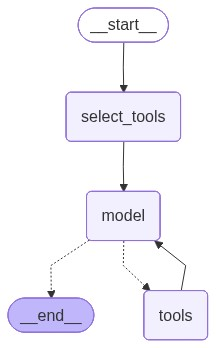

In [6]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings 

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """Alat kalkulator sederhana. Masukan harus berupa ekspresi matematika."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

embeddings =  OllamaEmbeddings(model="nomic-embed-text",base_url="http://localhost:11434")

model = ChatOpenAI(model=default_model_name,temperature=0.1)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

{'first_model': {'messages': AIMessage(content='', id='5a76ce48-1d29-4b6d-9c74-bec5cf3ef544', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "hitler's age if still alive?"}, 'id': '6c2df7103a374afdb66a42b4df30ffcb', 'type': 'tool_call'}])}}


c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='No good DuckDuckGo Search Result was found', name='duckduckgo_search', id='5968dc50-dc9e-4052-a1fc-86e7fc9cafd2', tool_call_id='6c2df7103a374afdb66a42b4df30ffcb')]}}


KeyError: 'selected_tools'